# 6章

## ハイパーパラメータの検証

ハイパーパラメータの調整のために訓練データのうち適当な割合で検証データを作る。
ハイパーパラメータの試行錯誤の評価をテストデータ使ってしまうとテストデータに過学習した状態になってしまう。
ハイパーパラメータを調整するにはハイパーパラメータ専用の検証データが必要になる。

ハイパーパラメータの探索はランダムにサンプリングして結果を見ながら範囲を狭めていく方法がよく取られる。規則的な探索よりもランダムにサンプリングして探索したほうが良い結果になることは報告されているそうだ。

今回は学習率`lr`とWeight decayの係数でハイパーパラメータの検証を行ってみる。層の深さとか他にもいろいろハイパーパラメータはあるけれどもとりあえずこれで。

val acc:0.55 | lr:0.00422712871121813, weight decay:3.6519487799222196e-06
val acc:0.09 | lr:1.3121957994649819e-05, weight decay:1.3163335411816177e-08
val acc:0.06 | lr:1.0118940511137029e-06, weight decay:1.0403926869461057e-06
val acc:0.21 | lr:0.001093943414512269, weight decay:7.658188868905278e-07
val acc:0.27 | lr:0.0009981161318134845, weight decay:1.1426075783623589e-05
val acc:0.1 | lr:7.517600604386361e-06, weight decay:1.34778514998323e-06
val acc:0.05 | lr:4.45636328629693e-06, weight decay:2.555881716170962e-05
val acc:0.51 | lr:0.005402382664585619, weight decay:1.3880845868079875e-08
val acc:0.14 | lr:1.2954768621662212e-06, weight decay:2.2819163308276234e-05
val acc:0.43 | lr:0.002374193206604688, weight decay:5.254070550571359e-06
val acc:0.05 | lr:5.994383650411147e-05, weight decay:4.1430780419356534e-05
val acc:0.06 | lr:7.535810698142185e-06, weight decay:7.001066810080966e-05
val acc:0.26 | lr:0.0015046506802684192, weight decay:4.410234812298009e-06
val acc:0.

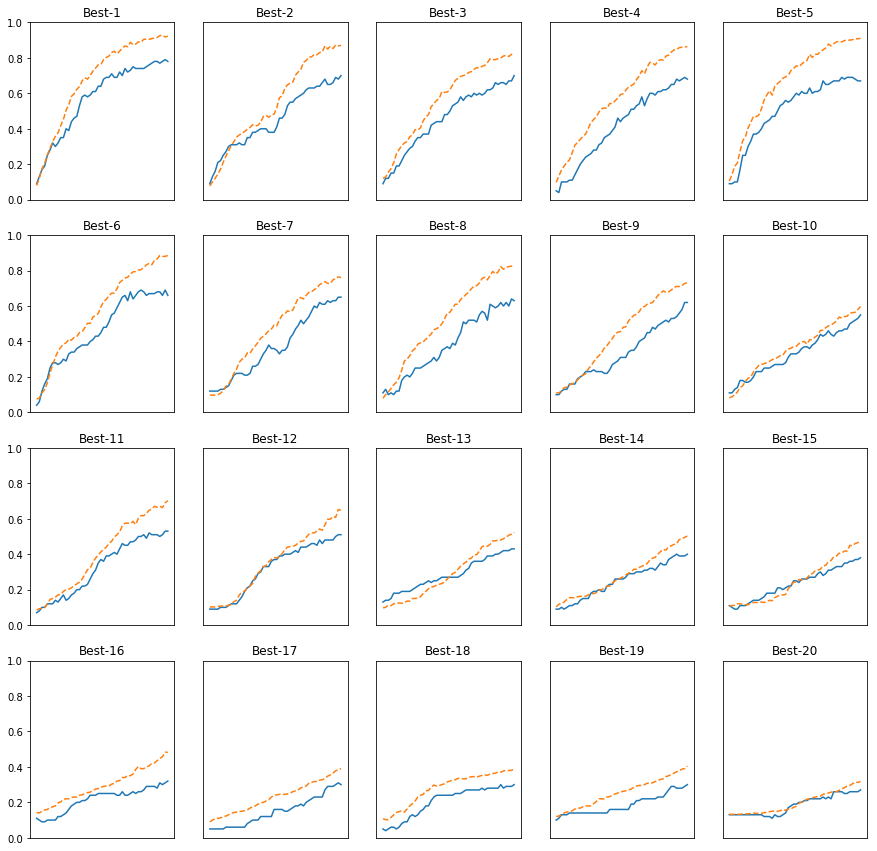

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize = (15, 15))

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

学習係数`lr`を$10^{-8}$から$10^{-2}$の範囲でランダムに、Weight decayの係数を$10^{-8}$から$10^{-4}$の範囲でランダムに選んで100回くりかえしてよかったものを見比べて値の範囲を狭めていく。

今回の場合は`lr`が$0.001$から$0.01$、Weight decayが$10^{-8}$から$10^{-5}$あたりが良さげ。
この中からまたランダムにやって探索をするというのを繰り返していくらしい。

他の方法としてはベイズ最適化とか言うのがあるらしいけれども本では名前が紹介された程度。